## Load Packages and Data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.stats import spearmanr
import seaborn as sns


#We are reading in raw data with the following columns
#  Uniq_ID is the plot identifier
#  RGBFirstArea is the area of green vegetation from a mid-season flight 
#  RGBLastArea is the area of green vegetation from a flight just prior to harvesting the peanuts
#  RGB_LMA_<letter> represent data from the red, green, and blue bands of an RGB camera
#  RD_LMA_<code>_<number> represent the 10 bands of data from the RedEdge Dual System. The <code> is the length of the wavelength range, and the <number> is the center wavelength
#  Visual Last is the tradional visual rating



BioMaster = pd.read_csv("test-data.tsv", sep='\t') 
BioMaster.head(5)



,UNIQ_ID,RGBFirstArea,RGBLastArea,RGB_LMA_R,RGB_LMA_G,RGB_LMA_B,RD_LMA_B28_444,RD_LMA_A32_475,RD_LMA_B14_531,RD_LMA_A27_560,RD_LMA_B16_650,RD_LMA_A14_668,RD_LMA_B10_705,RD_LMA_A12_717,RD_LMA_B18_740,RD_LMA_A57_842,VisualLast
0,LS00162,98.641577,89.862692,74.704877,83.187529,51.784749,0.017837,0.020963,0.057479,0.071391,0.038286,0.028845,0.112338,0.180688,0.307410,0.392974,4
1,LS00464,98.508733,91.982370,66.531275,77.941556,49.824349,0.014892,0.017125,0.050215,0.062836,0.027952,0.019755,0.095963,0.174730,0.362071,0.478253,3
2,LS00779,94.978151,58.271181,80.226959,81.511840,61.179499,0.025180,0.028541,0.055323,0.066034,0.053596,0.047605,0.103637,0.135235,0.176766,0.222383,7
3,LS00808,96.990722,63.030886,80.255059,82.859460,62.125469,0.022154,0.025058,0.052169,0.062942,0.046236,0.039985,0.097284,0.134748,0.187475,0.234241,6
4,LS01108,98.989718,74.552991,75.712637,82.045530,61.123376,0.017571,0.019860,0.046419,0.058187,0.031626,0.025321,0.091241,0.151262,0.265239,0.348806,4


## Calculate Defoliation

In [13]:
BioMaster['RGB_Defol']= BioMaster['RGBFirstArea']-BioMaster['RGBLastArea']

## Calculate Vegetation Indices (ie feature combinations)

In [14]:
#NDVI
#chose 842 and 668 because of rank change
BioMaster["NDVI"]=(BioMaster["RD_LMA_A57_842"]-BioMaster["RD_LMA_A14_668"])/(BioMaster["RD_LMA_A57_842"]+BioMaster["RD_LMA_A14_668"]) 

#NDRE
#chose 842 and 717 because 717 is less correlated with 842 than 740 is
BioMaster["NDRE"]=(BioMaster["RD_LMA_A57_842"]-BioMaster["RD_LMA_A12_717"])/(BioMaster["RD_LMA_A57_842"]+BioMaster["RD_LMA_A12_717"])

#SAVI
#chose 842 and 668 because of rank change
BioMaster["SAVI"]=(1.5*(BioMaster["RD_LMA_A57_842"]-BioMaster["RD_LMA_A14_668"]))/(BioMaster["RD_LMA_A57_842"]+BioMaster["RD_LMA_A14_668"]+0.5)

#DVI
#chose 842 and 668 because of rank change
BioMaster["DVI"]=BioMaster["RD_LMA_A57_842"]-BioMaster["RD_LMA_A14_668"]

#EVI
#incorporates the blue band
BioMaster["EVI"]=(2.5*(BioMaster["RD_LMA_A57_842"]-BioMaster["RD_LMA_A14_668"]))/(BioMaster["RD_LMA_A57_842"]+6*BioMaster["RD_LMA_A14_668"]-7.5*BioMaster["RD_LMA_A32_475"] +1)

#SRPI
#incorporates the 444 blue band
BioMaster["SRPI"]=BioMaster["RD_LMA_B28_444"]/(BioMaster["RD_LMA_A14_668"])

#RARSa
#uses 705 which was not shown as 'important'
BioMaster["RARSa"]=BioMaster["RD_LMA_A14_668"]/BioMaster["RD_LMA_B10_705"]

#MCARI
#going as close as I can to equation
BioMaster["MCARI"]=((BioMaster["RD_LMA_B10_705"] - BioMaster["RD_LMA_A14_668"]) - (0.2*(BioMaster["RD_LMA_B10_705"]- BioMaster["RD_LMA_A27_560"])))*(BioMaster["RD_LMA_B10_705"]/BioMaster["RD_LMA_A14_668"])

#MTVI-1
#going as close as I can to equation
BioMaster["MTVI-1"]= 1.2*(1.2 *(BioMaster["RD_LMA_A57_842"]-BioMaster["RD_LMA_A27_560"]) - 2.5*(BioMaster["RD_LMA_A14_668"]-BioMaster["RD_LMA_A27_560"]))

#TVI
#going as close as I can to equation
BioMaster["TVI"]=0.5 * (120 * (BioMaster["RD_LMA_B18_740"]-BioMaster["RD_LMA_A27_560"])-200*(BioMaster["RD_LMA_A14_668"]-BioMaster["RD_LMA_A27_560"]))

#PSSRb
#going as close as I can to equation
BioMaster["PSSRb"]=BioMaster["RD_LMA_A57_842"]/BioMaster["RD_LMA_B16_650"]

#VARI
#RGB, uses all 3 bands
BioMaster["VARI"] = (BioMaster["RGB_LMA_G"]-BioMaster["RGB_LMA_R"])/(BioMaster["RGB_LMA_G"]+BioMaster["RGB_LMA_R"]-BioMaster["RGB_LMA_B"])

#CN1
#wanted to use 'most important' rgb fts alone
BioMaster["CN1"] = (BioMaster["RGB_LMA_B"]-BioMaster["RGB_LMA_R"])/(BioMaster["RGB_LMA_B"]+BioMaster["RGB_LMA_R"])

#CN2
#wanted to use 'most important' rgb fts alone
BioMaster["CN2"] = BioMaster["RGB_LMA_B"]/BioMaster["RGB_LMA_R"]

## Standardize Data using Mean and Standard Deviation

In [15]:
scaler=StandardScaler()
BioMaster[['VisualLast', 'RGB_Defol','RGB_LMA_R','RGB_LMA_G','RGB_LMA_B','RD_LMA_B28_444', 'RD_LMA_A32_475','RD_LMA_B14_531','RD_LMA_A27_560','RD_LMA_B16_650','RD_LMA_A14_668','RD_LMA_B10_705','RD_LMA_A12_717','RD_LMA_B18_740','RD_LMA_A57_842','NDVI','NDRE', 'SAVI','DVI', 'SRPI', 'EVI', 'RARSa', 'MCARI', 'MTVI-1', 'TVI', 'PSSRb', 'VARI', 'CN1', 'CN2']]=scaler.fit_transform(BioMaster[['VisualLast', 'RGB_Defol','RGB_LMA_R','RGB_LMA_G','RGB_LMA_B','RD_LMA_B28_444', 'RD_LMA_A32_475','RD_LMA_B14_531','RD_LMA_A27_560','RD_LMA_B16_650','RD_LMA_A14_668','RD_LMA_B10_705','RD_LMA_A12_717','RD_LMA_B18_740','RD_LMA_A57_842','NDVI','NDRE', 'SAVI','DVI', 'SRPI', 'EVI', 'RARSa', 'MCARI', 'MTVI-1', 'TVI', 'PSSRb', 'VARI', 'CN1', 'CN2']])

## Look at how data is distributed, and the relationship between features

In [22]:
names = ['VisualLast', 'RGB_Defol','RGB_LMA_R','RGB_LMA_G','RGB_LMA_B','RD_LMA_B28_444', 'RD_LMA_A32_475','RD_LMA_B14_531','RD_LMA_A27_560','RD_LMA_B16_650','RD_LMA_A14_668','RD_LMA_B10_705','RD_LMA_A12_717','RD_LMA_B18_740','RD_LMA_A57_842','NDVI','NDRE', 'SAVI','DVI', 'SRPI', 'EVI', 'RARSa', 'MCARI', 'MTVI-1', 'TVI', 'PSSRb', 'VARI', 'CN1', 'CN2']
for i in names:
    print(i)
    print(scipy.stats.shapiro(BioMaster[i])) #if pval > 0.05 than we fail to reject the null hypothesis that the data are normally distributed
    #plt.show(sns.displot(data=BioMaster, x= i)) #Remove the hash at this line if you want to visualize the data

VisualLast
ShapiroResult(statistic=0.9525395631790161, pvalue=0.2129373848438263)
RGB_Defol
ShapiroResult(statistic=0.9261454343795776, pvalue=0.04375395551323891)
RGB_LMA_R
ShapiroResult(statistic=0.97713303565979, pvalue=0.7612720727920532)
RGB_LMA_G
ShapiroResult(statistic=0.9181830883026123, pvalue=0.027431994676589966)
RGB_LMA_B
ShapiroResult(statistic=0.9482511878013611, pvalue=0.16483892500400543)
RD_LMA_B28_444
ShapiroResult(statistic=0.9586988091468811, pvalue=0.3052169382572174)
RD_LMA_A32_475
ShapiroResult(statistic=0.964443564414978, pvalue=0.42057499289512634)
RD_LMA_B14_531
ShapiroResult(statistic=0.9858714938163757, pvalue=0.9558008909225464)
RD_LMA_A27_560
ShapiroResult(statistic=0.974070131778717, pvalue=0.6740160584449768)
RD_LMA_B16_650
ShapiroResult(statistic=0.9898865222930908, pvalue=0.9916613698005676)
RD_LMA_A14_668
ShapiroResult(statistic=0.9822761416435242, pvalue=0.8917912244796753)
RD_LMA_B10_705
ShapiroResult(statistic=0.9765630960464478, pvalue=0.745246231

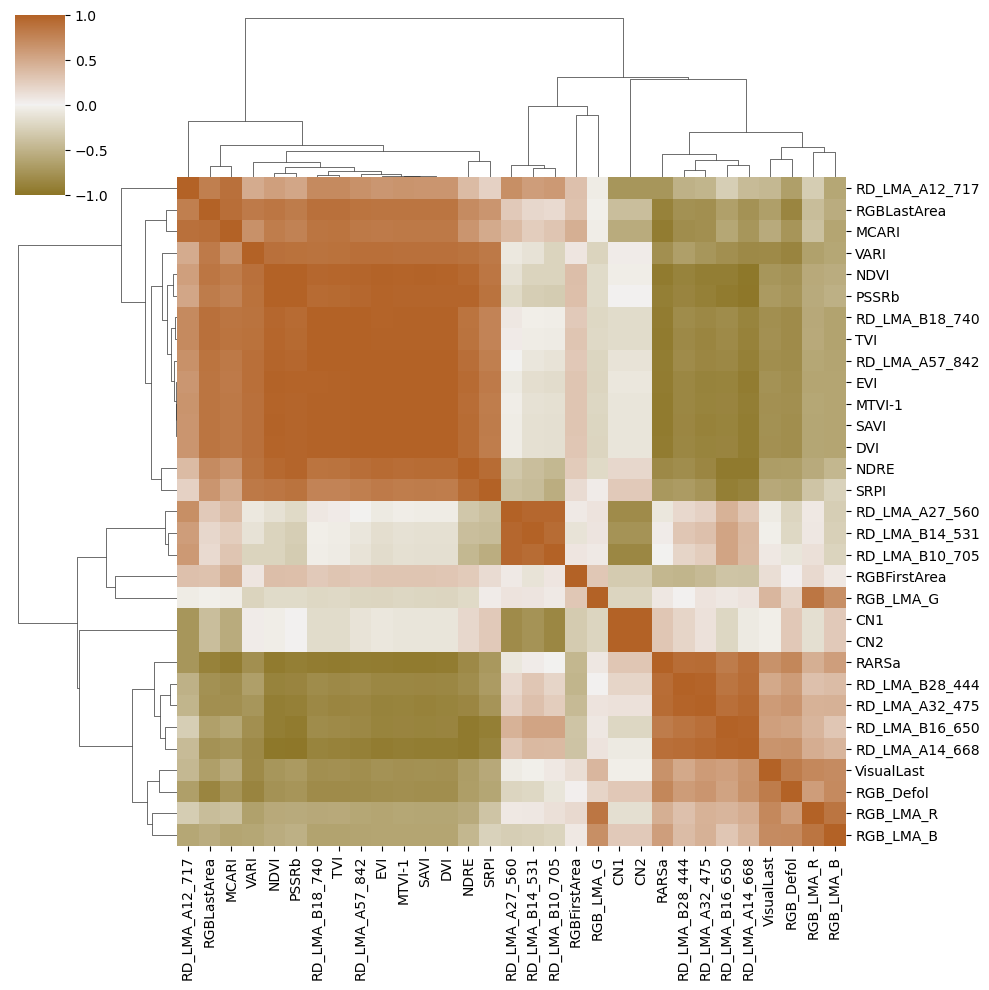

In [24]:
spearcorr_mat = BioMaster.corr(method = 'spearman')
ax = sns.clustermap(spearcorr_mat, center=0, cmap=sns.diverging_palette(67,32,s=88,center="light", as_cmap=True), vmin=-1, vmax=1)